In [1]:
%matplotlib inline

import pickle

from keras.datasets import mnist
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

/home/qkt/.local/share/virtualenvs/sgan-techniques-WxACZbr4/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
sns.set_style('whitegrid')

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_test = (x_test.astype(np.float32) - 127.5) / 127.5

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

In [4]:
def dense_discriminator(x, is_training, num_classes=10, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse) as scope:
        x = tf.layers.flatten(x)
        x = tf.layers.dense(x, 512, activation=tf.nn.leaky_relu)
        x = tf.layers.dense(x, 256, activation=tf.nn.leaky_relu)
        features = tf.layers.dense(x, 128, activation=tf.nn.leaky_relu)
        logits = tf.layers.dense(features, num_classes + 1)
        output = tf.nn.softmax(logits)
        return output, logits, features

In [5]:
def dense_generator(x, is_training, output_shape=(28, 28, 1), reuse=False):
    with tf.variable_scope('generator', reuse=reuse) as scope:
        x = tf.layers.dense(x, 256, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, 512, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = tf.layers.dense(x, np.prod(output_shape), activation=tf.nn.tanh)
        x = tf.reshape(x, (-1,) + output_shape)
        
        return x

In [6]:
def build_dense_model(x_real, z, is_training, num_classes=10, output_shape=(28, 28, 1)):
    d_real_prob, d_real_logits, d_real_features = dense_discriminator(
        x_real, is_training, num_classes=num_classes, reuse=False,
    )
    x_fake = dense_generator(z, is_training, output_shape=output_shape)
    d_fake_prob, d_fake_logits, d_fake_features = dense_discriminator(
        x_fake, is_training, num_classes=num_classes, reuse=True,
    )
    return d_real_prob, d_real_logits, d_real_features, d_fake_prob, d_fake_logits, d_fake_features, x_fake

In [7]:
def standard_loss_accuracy(d_real_prob, d_real_logits, d_real_features,
                           d_fake_prob, d_fake_logits, d_fake_features,
                           extended_label, labeled_mask):
    epsilon = 1e-8
    
    ### Discriminator loss
    # Supervised loss for discriminator
    d_ce = tf.nn.softmax_cross_entropy_with_logits_v2(logits=d_real_logits,
                                                      labels=extended_label)
    d_loss_supervised = tf.reduce_sum(labeled_mask * d_ce) / (tf.reduce_sum(labeled_mask) + epsilon)
    # Unsupervised loss for discriminator
    # data is real
    # subtract from one due to log --> log of (1 - 0) is 0, therefore loss is 0 for d_real_prob[i, -1] == 0
    prob_real_be_real = 1 - d_real_prob[:, -1] + epsilon
    logprob = tf.log(prob_real_be_real)
    d_loss_unsupervised1 = -1 * tf.reduce_mean(logprob)
    # data is fake
    prob_fake_be_fake = d_fake_prob[:, -1] + epsilon
    logprob = tf.log(prob_fake_be_fake)
    d_loss_unsupervised2 = -1 * tf.reduce_mean(logprob)
    
    d_loss = d_loss_supervised + d_loss_unsupervised1 + d_loss_unsupervised2
    
    ### Generator loss
    # fake data is mistaken to be real
    prob_fake_be_real = 1 - d_fake_prob[:, -1] + epsilon
    logprob = tf.log(prob_fake_be_real)
    g_loss_probs = -1 * tf.reduce_mean(logprob)
    
    mean_real_features = tf.reduce_mean(d_real_features, axis=0)
    mean_fake_features = tf.reduce_mean(d_fake_features, axis=0)
    g_loss_fm = tf.reduce_mean(tf.square(mean_real_features - mean_fake_features))
    
    g_loss = g_loss_probs + g_loss_fm
    
    ### Accuracy
    correct_prediction = tf.equal(tf.argmax(d_real_prob[:, :-1], 1),
                                  tf.argmax(extended_label[:, :-1], 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return d_loss_supervised, d_loss_unsupervised1, d_loss_unsupervised2, d_loss, g_loss, accuracy

In [8]:
def optimizer(d_loss, g_loss, d_learning_rate, g_learning_rate):
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        all_vars = tf.trainable_variables()
        d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in all_vars if var.name.startswith('generator')]

        d_optimizer = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        g_optimizer = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        return d_optimizer, g_optimizer

In [9]:
def extend_labels(labels):
    # add extra label for fake data
    extended_label = tf.concat([labels, tf.zeros([tf.shape(labels)[0], 1])], axis=1)

    return extended_label

In [10]:
def moving_average(x, n=10):
    ret = np.cumsum(x)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [11]:
def execute(x_train, y_train, x_test, y_test,
            epochs=50000, batch_size=32, test_steps=500, num_labeled_examples=None, 
            periodic_labeled_batch=False, periodic_labeled_batch_frequency=10,
            x_height=28, x_width=28, num_channels=1, latent_size=100):
    tf.reset_default_graph()
    
    num_classes = np.unique(y_train).shape[0]
    y_test = to_categorical(y_test, num_classes=num_classes)
    
    default_learning_rate = 0.001
    
    x = tf.placeholder(tf.float32, name='x', shape=(None, x_height, x_width, num_channels))
    label = tf.placeholder(tf.float32, name='label', shape=(None, num_classes))
    labeled_mask = tf.placeholder(tf.float32, name='labeled_mask', shape=(None,))
    z = tf.placeholder(tf.float32, name='z', shape=(None, latent_size))
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    g_learning_rate = tf.placeholder(tf.float32, name='g_learning_rate')
    d_learning_rate = tf.placeholder(tf.float32, name='d_learning_rate')
    
    model = build_dense_model(x, z, is_training)
    extended_label = extend_labels(label)
    d_real_prob, d_real_logits, d_real_features, d_fake_prob, d_fake_logits, d_fake_features, x_fake = model
    loss_acc = standard_loss_accuracy(d_real_prob, d_real_logits, d_real_features,
                                      d_fake_prob, d_fake_logits, d_fake_features,
                                      extended_label, labeled_mask)
    _, _, _, d_loss, g_loss, accuracy = loss_acc
    d_optimizer, g_optimizer = optimizer(d_loss, g_loss, d_learning_rate, g_learning_rate)
    
    if num_labeled_examples is None:
        global_mask = np.ones(x_train.shape[0])
        periodic_labeled_batch = False
    else:
        global_mask = np.zeros(x_train.shape[0])
        for cls in np.unique(y_train):
            idx = y_train == cls
            idx = np.random.choice(np.flatnonzero(idx), num_labeled_examples // num_classes, replace=False)
            global_mask[idx] = 1.0
        
    
    train_d_losses, train_g_losses, train_accuracies = [], [], []
    test_d_losses, test_g_losses, test_accuracies = [], [], []
    
    def test_gan(epoch):
        d_batch_losses, g_batch_losses, batch_accuracies = [], [], []
        
        test_size = x_test.shape[0]
        batch_size = test_size // 100
        test_mask = np.ones(test_size)
        for i in range(0, test_size, batch_size):
            z_test = np.random.normal(0, 1, (batch_size, latent_size))
            test_mask = np.ones(test_size)
            test_dictionary = {
                x: x_test[i:i+batch_size],
                z: z_test,
                label: y_test[i:i+batch_size],
                labeled_mask: test_mask[i:i+batch_size],
                is_training: False
            }

            test_d_loss = d_loss.eval(feed_dict=test_dictionary)
            test_g_loss = g_loss.eval(feed_dict=test_dictionary)
            test_accuracy = accuracy.eval(feed_dict=test_dictionary)
            
            d_batch_losses.append(test_d_loss)
            g_batch_losses.append(test_g_loss)
            batch_accuracies.append(test_accuracy)

        test_d_loss = np.mean(d_batch_losses)
        test_g_loss = np.mean(g_batch_losses)
        test_accuracy = np.mean(batch_accuracies)
        
        test_d_losses.append(test_d_loss)
        test_g_losses.append(test_g_loss)
        test_accuracies.append(test_accuracy)

        print(epoch, test_d_loss, test_g_loss, test_accuracy)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            if periodic_labeled_batch and epoch % periodic_labeled_batch_frequency == 0:
                idx = np.flatnonzero(global_mask)
                x_batch = x_train[idx]
                y_batch = y_train[idx]
                mask = global_mask[idx]
                z_batch = np.random.normal(0, 1, (len(idx), latent_size))
                
                x_batches = [x_batch[i:i+batch_size] for i in range(0, len(x_batch), batch_size)]
                y_batches = [y_batch[i:i+batch_size] for i in range(0, len(y_batch), batch_size)]
                masks = [mask[i:i+batch_size] for i in range(0, len(mask), batch_size)]
                z_batches = [z_batch[i:i+batch_size] for i in range(0, len(z_batch), batch_size)]
                
                learning_rate = default_learning_rate / len(x_batches)
            else:
                idx = np.random.randint(0, x_train.shape[0], batch_size)
                x_batch = x_train[idx]
                y_batch = y_train[idx]
                mask = global_mask[idx]
                z_batch = np.random.normal(0, 1, (batch_size, latent_size))
                
                x_batches = [x_batch]
                y_batches = [y_batch]
                masks = [mask]
                z_batches = [z_batch]
                
                learning_rate = default_learning_rate
            
            train_d_loss_batches, train_g_loss_batches, train_accuracy_batches = [], [], []
            for x_batch, y_batch, mask, z_batch in zip(x_batches, y_batches, masks, z_batches):
                y_batch = to_categorical(y_batch, num_classes=num_classes)
                train_dictionary = {
                    x: x_batch,
                    z: z_batch,
                    label: y_batch,
                    labeled_mask: mask,
                    g_learning_rate: learning_rate,
                    d_learning_rate: learning_rate,
                    is_training: True
                }
                d_optimizer.run(feed_dict=train_dictionary)
                g_optimizer.run(feed_dict=train_dictionary)

                train_d_loss = d_loss.eval(feed_dict=train_dictionary)
                train_g_loss = g_loss.eval(feed_dict=train_dictionary)
                train_accuracy = accuracy.eval(feed_dict=train_dictionary)
                
                train_d_loss_batches.append(train_d_loss)
                train_g_loss_batches.append(train_g_loss)
                train_accuracy_batches.append(train_accuracy)
            
            train_d_losses.append(np.mean(train_d_loss_batches))
            train_g_losses.append(np.mean(train_g_loss_batches))
            train_accuracies.append(np.mean(train_accuracy_batches))
            
            if epoch % test_steps == 0:
                test_gan(epoch)
        test_gan(epochs)
    
    return train_d_losses, train_g_losses, train_accuracies, test_d_losses, test_g_losses, test_accuracies

In [12]:
def run_test(output_file, num_labeled_examples=None,
             periodic_labeled_batch=False, periodic_labeled_batch_frequency=10):
    results = execute(x_train, y_train, x_test, y_test, num_labeled_examples=num_labeled_examples,
                      periodic_labeled_batch=periodic_labeled_batch,
                      periodic_labeled_batch_frequency=periodic_labeled_batch_frequency)
    train_d_losses, train_g_losses, train_accuracies, test_d_losses, test_g_losses, test_accuracies = results
    with open(output_file, 'wb') as f:
        pickle.dump({
            'train_d_losses': train_d_losses,
            'train_g_losses': train_g_losses,
            'train_accuracies': train_accuracies,
            'test_d_losses': test_d_losses,
            'test_g_losses': test_g_losses,
            'test_accuracies': test_accuracies
        }, f)
    return results

In [13]:
def plot_losses(results):
    train_d_losses, train_g_losses, _, test_d_losses, test_g_losses, _ = results
    
    average_train_d_losses = moving_average(train_d_losses, 10)
    average_train_g_losses = moving_average(train_g_losses, 10)

    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(len(average_train_d_losses)), average_train_d_losses, label='discriminator training loss')
    plt.plot(np.arange(len(average_train_g_losses)), average_train_g_losses, label='generator training loss')
    plt.plot(np.arange(len(test_d_losses)) * 500, test_d_losses, label='discriminator test loss')
    plt.plot(np.arange(len(test_g_losses)) * 500, test_g_losses, label='generator test loss')
    plt.legend()

In [14]:
def plot_accuracies(results):
    _, _, train_accuracies, _, _, test_accuracies = results
    
    average_train_accuracies = moving_average(train_accuracies, 10)

    plt.figure(figsize=(15, 8))
    plt.plot(np.arange(len(average_train_accuracies)), average_train_accuracies, label='training accuracy')
    plt.plot(np.arange(len(test_accuracies)) * 500, test_accuracies, label='test accuracy')
    plt.legend()

In [15]:
results = run_test('improved-gan-all-v2.pkl')

0 5.163363 0.42175978 0.095699996
500 0.5646263 6.160448 0.893
1000 0.78658015 2.502395 0.9262
1500 0.6304523 2.6582613 0.93759996
2000 0.85909635 3.8094614 0.94259995
2500 1.423728 1.5584323 0.94500005
3000 0.8455994 6.6855636 0.9504001
3500 0.5792947 3.6290698 0.94859993
4000 1.1251017 2.2239857 0.9513999
4500 0.88828695 2.689755 0.9505
5000 1.1030582 3.476858 0.9536
5500 1.3002797 2.1109414 0.9455
6000 1.4445064 1.6552038 0.94839996
6500 1.4823711 1.9089589 0.94890004
7000 1.1643506 2.7643557 0.9562
7500 1.2215796 1.6459181 0.96629995
8000 1.2906536 1.9642171 0.9587
8500 1.4909949 1.3929889 0.9583001
9000 1.2562853 2.2230675 0.96949995
9500 1.3512863 1.5225351 0.9632
10000 1.7583191 1.488319 0.96259993
10500 1.5007052 1.3218895 0.96450007
11000 1.5183598 1.4925548 0.96489996
11500 1.3796939 1.7160387 0.9698999
12000 1.6918224 2.2080941 0.96449995
12500 1.6687844 1.8375533 0.96770006
13000 1.5969262 1.6250876 0.9531
13500 1.5011458 1.8276781 0.96889997
14000 1.4403503 2.0317922 0.974

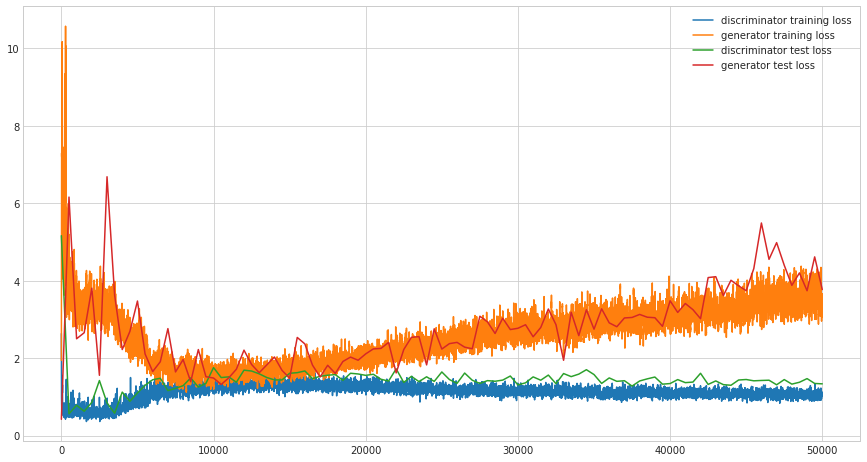

In [16]:
plot_losses(results)

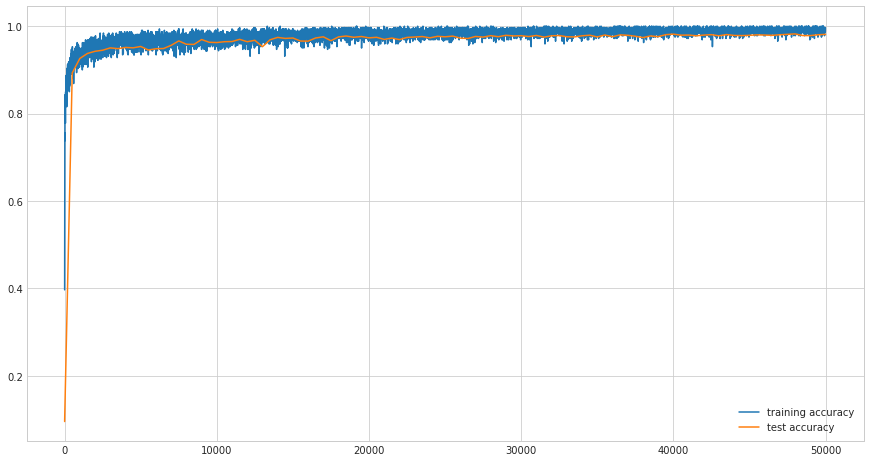

In [17]:
plot_accuracies(results)

In [18]:
results = run_test('improved-gan-100-periodic-v2.pkl', num_labeled_examples=100, periodic_labeled_batch=True)

0 4.2589765 0.29112485 0.2401
500 1.3260597 3.182029 0.7267
1000 2.0621135 2.6659238 0.7271
1500 2.3218288 1.5828317 0.76159996
2000 1.7156699 4.010791 0.82310015
2500 1.3357292 3.6107962 0.83709997
3000 1.8074838 4.150423 0.8346001
3500 2.7484088 3.5865314 0.813
4000 2.0180254 3.5006366 0.83709997
4500 2.1674643 1.1427245 0.7881
5000 1.8969812 2.3709445 0.8312
5500 2.3321862 2.2057798 0.80520004
6000 2.352522 2.2297654 0.85060006
6500 1.9920498 1.6078613 0.8005
7000 2.325144 1.8179016 0.8518
7500 2.2758617 2.22169 0.8642
8000 2.1615539 2.0689316 0.8664
8500 2.3266978 2.2234812 0.85260004
9000 1.9305894 2.0537558 0.89439994
9500 2.256368 2.137929 0.86300004
10000 1.9740933 1.2100816 0.874
10500 2.5548346 2.4615176 0.87049997
11000 2.3759239 1.8729224 0.8696
11500 2.2194834 2.7308185 0.8907
12000 2.284501 1.9984 0.875
12500 2.0902586 1.7112943 0.8833999
13000 2.4097047 2.1672912 0.90389997
13500 2.1263127 2.2354975 0.90410006
14000 2.0867388 2.0537322 0.8983
14500 2.0700235 1.4493098 0.

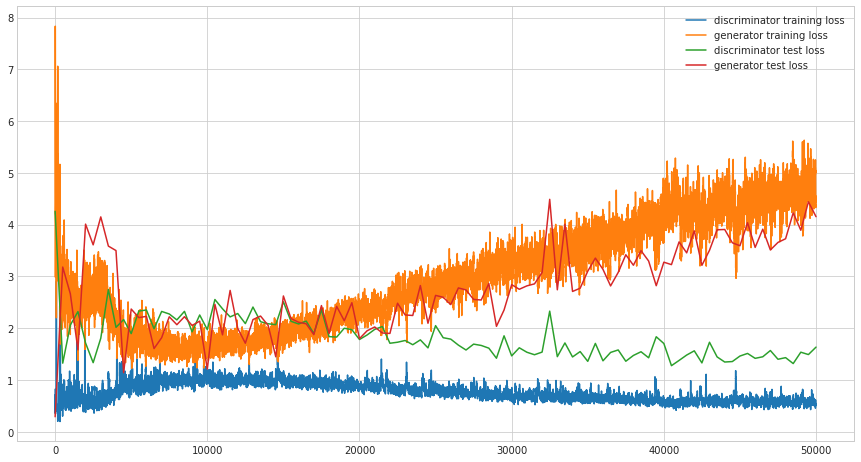

In [19]:
plot_losses(results)

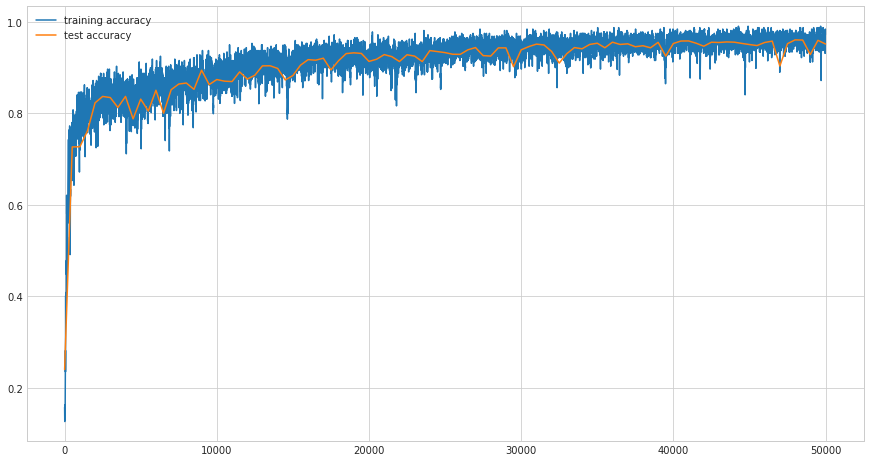

In [20]:
plot_accuracies(results)

In [21]:
results = run_test('improved-gan-300-periodic-v2.pkl', num_labeled_examples=300, periodic_labeled_batch=True)

0 4.2598095 0.2809478 0.36060002
500 1.5264175 1.6151005 0.7878999
1000 1.6448005 1.203145 0.8153
1500 1.4669588 2.871966 0.84859985
2000 1.8494116 1.9008011 0.8153
2500 1.9684143 1.9018288 0.84740007
3000 1.8052372 3.1040292 0.875
3500 2.0541353 1.9924294 0.866
4000 2.29898 1.7965912 0.8643
4500 2.2991982 1.5424907 0.8969001
5000 2.102416 1.9269677 0.86950004
5500 2.254534 1.8714699 0.8795
6000 2.4296389 2.1078613 0.90299994
6500 2.219682 0.92092633 0.8784
7000 2.6974423 1.3754272 0.87789994
7500 2.5918515 1.8702612 0.8885
8000 2.5339437 1.0427226 0.85990006
8500 2.5389152 1.1703451 0.8079
9000 2.3590727 1.453675 0.9032
9500 2.2442656 1.2637557 0.90419996
10000 2.4036605 1.0930336 0.90830004
10500 2.352093 1.4841315 0.9155999
11000 2.5556266 1.6616488 0.90359986
11500 2.2471123 1.3512028 0.9206
12000 2.2301204 1.8149043 0.8953
12500 2.2459226 1.3695052 0.92
13000 2.3243861 1.5230758 0.90340006
13500 2.2633636 1.5492738 0.927
14000 2.3005958 1.4452318 0.91090006
14500 2.488251 1.471622

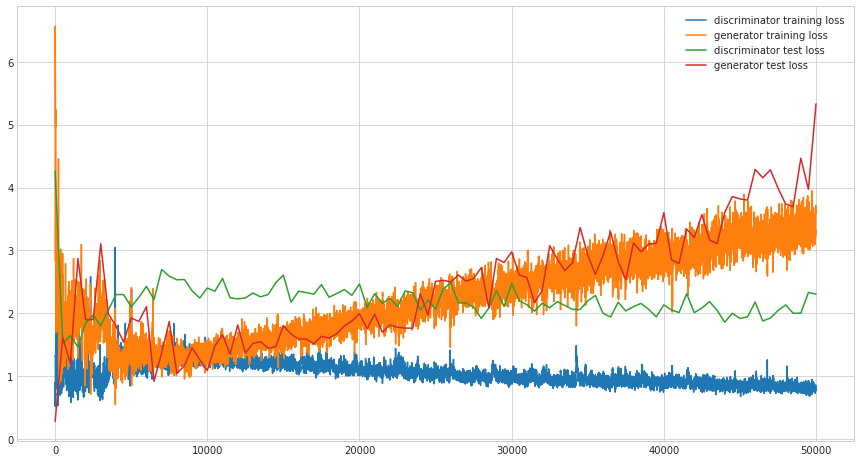

In [22]:
plot_losses(results)

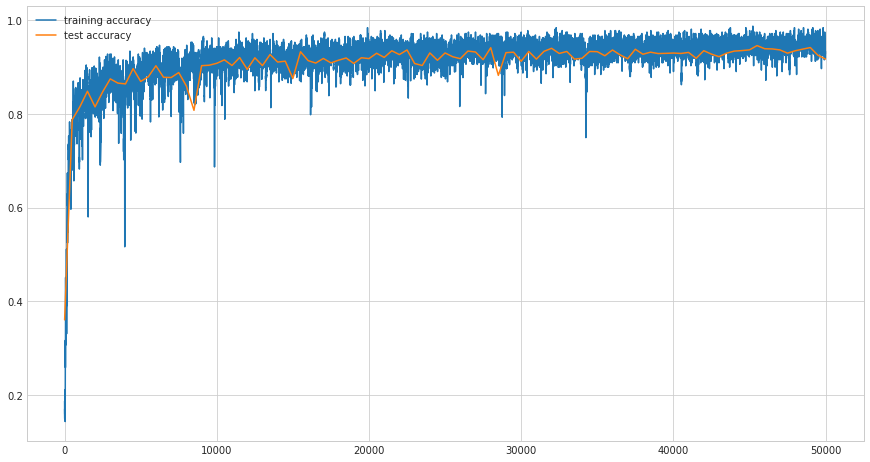

In [23]:
plot_accuracies(results)

In [24]:
results = run_test('improved-gan-500-periodic-v2.pkl', num_labeled_examples=500, periodic_labeled_batch=True)

0 4.174786 0.34482056 0.38879994
500 2.0499158 1.4854872 0.78740007
1000 2.1063163 0.79594225 0.8439001
1500 1.8654286 0.9957306 0.84400004
2000 1.8515745 0.94206953 0.8793
2500 1.9092002 1.0115092 0.8761999
3000 2.0746605 1.1475308 0.87149996
3500 2.015233 1.1100141 0.90589994
4000 2.2399783 1.544685 0.89759994
4500 2.5062299 0.6453264 0.82269996
5000 2.3969007 1.2043695 0.90730006
5500 2.3753235 1.432742 0.91089994
6000 2.505717 0.9256656 0.89149994
6500 2.3025768 1.1509398 0.9149999
7000 2.3693285 1.0082824 0.8833
7500 2.4158926 1.1019261 0.9100999
8000 2.2482982 1.5885636 0.90840006
8500 2.3359702 0.96765244 0.91550004
9000 2.5895607 1.3716516 0.9015999
9500 2.207647 1.5035137 0.9178999
10000 2.34337 1.5678139 0.91010004
10500 2.4608855 1.5719903 0.9193
11000 2.0887895 1.410503 0.91740006
11500 2.3405502 1.2332253 0.91019994
12000 2.5372941 1.7687198 0.9063999
12500 2.3023324 1.4244021 0.924
13000 2.411275 1.4852806 0.9191
13500 2.42012 1.5539393 0.918
14000 2.1736555 1.556837 0.93

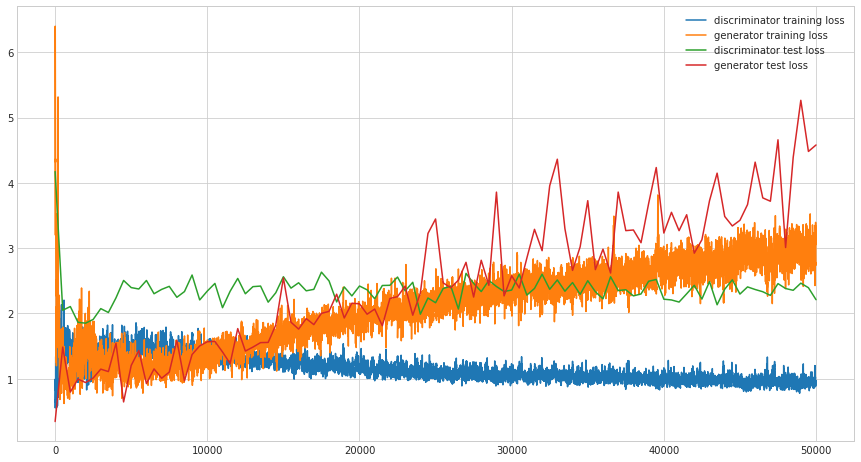

In [25]:
plot_losses(results)

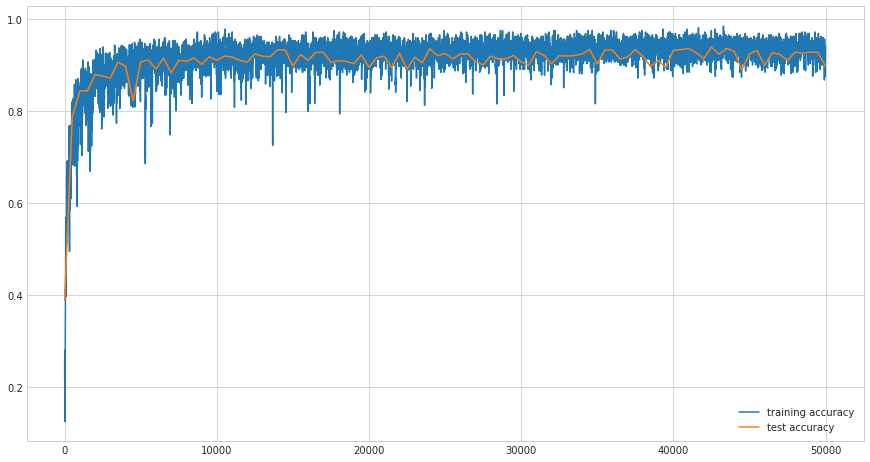

In [26]:
plot_accuracies(results)

In [27]:
results = run_test('improved-gan-1000-periodic-v2.pkl', num_labeled_examples=1000, periodic_labeled_batch=True)

0 4.2498217 0.2721359 0.34110004
500 2.3039758 0.8056715 0.75960004
1000 1.9218746 0.8918956 0.8807
1500 1.7029728 1.1871269 0.867
2000 2.1492922 0.7849906 0.8758
2500 2.1061544 0.78775483 0.8605
3000 2.1409194 0.9055941 0.8916999
3500 2.284276 0.8964956 0.90529996
4000 2.1044233 0.81710494 0.9176001
4500 2.1835825 0.86771506 0.9172
5000 2.343057 0.92935324 0.90709996
5500 2.1053252 1.0562211 0.9207001
6000 2.2873034 1.0752704 0.9182999
6500 2.177469 1.1253638 0.9001
7000 1.8280712 1.5284909 0.9229
7500 2.1542406 1.2245055 0.94289994
8000 2.1596854 1.4492896 0.9200001
8500 1.9628886 1.7876133 0.9288
9000 2.2039933 1.2898422 0.92090005
9500 2.1867416 1.3416458 0.9316
10000 2.2326035 1.4149194 0.8929
10500 2.3723803 1.9167567 0.9157999
11000 2.1306067 1.6093096 0.9329
11500 1.9661213 1.8569454 0.9454
12000 2.2509122 2.1330137 0.92090005
12500 1.890776 2.313642 0.93579996
13000 2.1156597 1.8897519 0.93819994
13500 2.1179776 2.1528895 0.9347
14000 2.5069623 2.2425194 0.90029997
14500 1.914

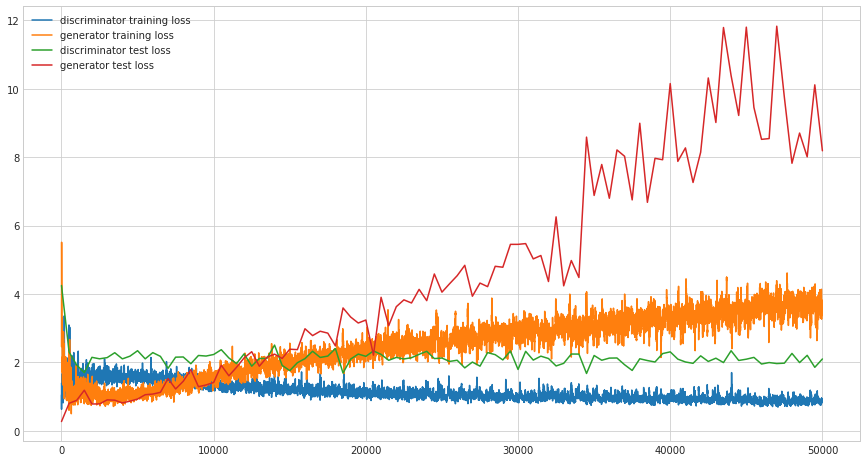

In [28]:
plot_losses(results)

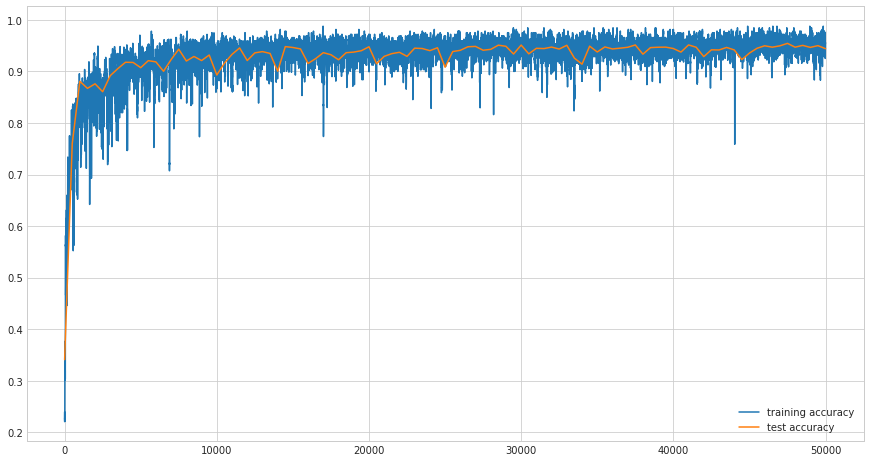

In [29]:
plot_accuracies(results)